In [103]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.stats import qmc
from torch.autograd import grad
import time

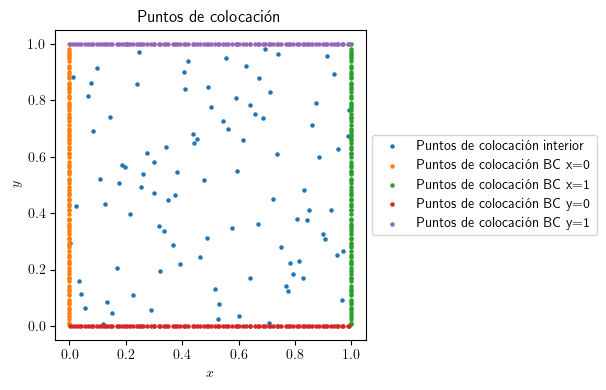

In [105]:
# Número de muestras en x y y
dom_samples = 100
x = np.linspace(0, 1, dom_samples)
y = np.linspace(0, 1, dom_samples)

# Malla del dominio
X, Y = np.meshgrid(x, y)

# Estrategia de muestreo LHS (Latin Hypercube Sampling)
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=dom_samples)

# límites inferior y superior del dominio
l_bounds = [ 0, 0]
u_bounds = [ 1, 1]
domain_xt = qmc.scale(sample, l_bounds, u_bounds)

# tensores de torch
x_ten = torch.tensor(domain_xt[:, 0], requires_grad = True).float().reshape(-1,1)
y_ten = torch.tensor(domain_xt[:, 1], requires_grad = True).float().reshape(-1,1)

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(domain_xt[:, 0], domain_xt[:, 1], s=5,
           label='Puntos de colocación interior')
ax.scatter(np.zeros_like(y_ten.detach().numpy()), y_ten.detach().numpy(),
           s=5, label='Puntos de colocación BC x=0')
ax.scatter(np.ones_like(y_ten.detach().numpy()), y_ten.detach().numpy(),
           s=5, label='Puntos de colocación BC x=1')
ax.scatter(x_ten.detach().numpy(), np.zeros_like(x_ten.detach().numpy()),
           s=5, label='Puntos de colocación BC y=0')
ax.scatter(x_ten.detach().numpy(), np.ones_like(x_ten.detach().numpy()),
           s=5, label='Puntos de colocación BC y=1')   
ax.set_title('Puntos de colocación')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$') 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.axis("image")
plt.tight_layout()

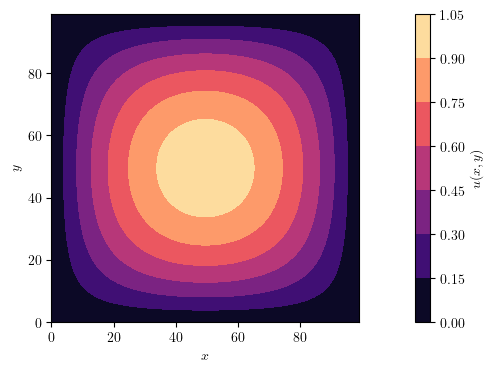

In [106]:
def u_analytic(x, y):
    return 16*(1 - x) * x * (1 - y) * y

# Mostrar la solución exacta u(x, y)
plt.figure(figsize=(6, 4))  
img = plt.contourf(u_analytic(X, Y), cmap='magma')
plt.colorbar(img, label='$u(x,y)$')   
plt.xlabel(r'$x$')   
plt.ylabel(r'$y$')
plt.axis("image")
plt.grid(False)

In [107]:
# parámetros de entrenamiento
hidden_layers = [2, 10, 10, 10, 1]
learning_rate = 0.001
training_iter = 20000

# Definir una función de pérdida (Error Cuadrático Medio) para entrenar la red
MSE_func = nn.MSELoss()

# Definir una clase de red neuronal con capas y neuronas definidas por el usuario
class NeuralNetwork(nn.Module):
    
    def __init__(self, hlayers):
        super(NeuralNetwork, self).__init__()
        
        layers = []
        for i in range(len(hlayers[:-2])):
            layers.append(nn.Linear(hlayers[i], hlayers[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hlayers[-2], hlayers[-1]))
        
        self.layers = nn.Sequential(*layers)
        self.init_params
        
    def init_params(self):
        """Xavier Glorot parameter initialization of the Neural Network
        """
        def init_normal(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # Xavier
        self.apply(init_normal)

    def forward(self, x):
        return self.layers(x)

In [108]:
# Crear una instancia de la red neuronal
u_pinn = NeuralNetwork(hidden_layers)
nparams = sum(p.numel() for p in u_pinn.parameters() if p.requires_grad)
print(f'Número de parámetros entrenables: {nparams}')

# Definir un optimizador (Adam) para entrenar la red
optimizer = torch.optim.Adam(u_pinn.parameters(), lr=0.001, 
                       betas= (0.9,0.999), eps = 1e-8)    

Número de parámetros entrenables: 261


In [111]:
# outer normal directional derivative on boundary of Omega (as a circle)
def outer_normal(x):

    middle = torch.tensor((0,0)).view(1,2)
    max_indices = torch.argmax(torch.abs(x - middle), dim=-1, keepdim=False)
    normals = torch.zeros_like(x)
    sign = torch.sign(x)
    temp_range = torch.arange(x.size(0))
    normals[temp_range, max_indices] = sign[temp_range, max_indices]

    return normals

In [109]:
# fundamental solution of Laplace equation in 2D
def fundamental_solution(x, y):

    distance = torch.norm(x - y, p=2, dim=1).view(-1,1)
    Phi_0 = -1/(2*torch.pi) * torch.log(distance)

    return Phi_0


# gradient of fundamental solution with respect to y
# grad Phi_0(x,y) = 1/(2π) * (x - y)/||x - y||²
def gradient_fundamental(x, y):

    distance = torch.norm(x - y, p=2, dim=1).view(-1,1)
    grad_Phi_0 = (1/(2*torch.pi)) * ((x - y) / distance**2)
    
    return grad_Phi_0

In [ ]:
    def calc_potentials_inside(model, x, y):

         
        side = 2  

        y = self.x_int
        normal_y = outer_normal(y)
        h_y = self(y) # boundary density, performs forward pass through  neural network with the input y
        domain = torch.cat([x_ten, y_ten], dim = 1)
        # single_layer
        G = fundamental_solution(x, y)
        grad_ones = torch.ones_like(h_y)
        dh_dy = torch.autograd.grad(h_y, y, grad_outputs=grad_ones, create_graph=True)[0]
        dh_dn = torch.sum(dh_dy * normal_y, dim=1).view(-1, 1)
        single_layer = 4*side*torch.mean(G * dh_dn)
        ################
        # double_layer
        dG_dy = gradient_fundamental(x, y)
        dG_dn = torch.sum(dG_dy * normal_y, dim=1).view(-1, 1)
        double_layer = 4*side*torch.mean(dG_dn * h_y)
        return single_layer.squeeze(), double_layer.squeeze()

    #------------------------------
    def predict_u_inside(self, x):
        single_layer, double_layer = self.vmapped_potential_inside(x)
        u_int_data = (single_layer.squeeze() - double_layer.squeeze()).view(-1, 1)
        return u_int_data

In [ ]:
# Definición de la función gradiente que calcula la derivada parcial de una salida con respecto a una entrada
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, 
                        grad_outputs=torch.ones_like(outputs), 
                        create_graph=True,
                        retain_graph=True)[0]

# Definición de la función de pérdida para la Red Neuronal de Ecuaciones Diferenciales Parciales (PINN)
def PINN_poisson_Loss(forward_pass, x_ten, y_ten, 
             lambda1 = 1, lambda2 = 1, lambda3 = 1, lambda4 = 1):



    # # Salida de la red neuronal y primeras y segundas derivadas
    # domain = torch.cat([x_ten, y_ten], dim = 1)
    # u = forward_pass(domain)
    # u_x = grad(u, x_ten)
    # u_xx = grad(u_x, x_ten)
    # u_y = grad(u, y_ten)
    # u_yy = grad(u_y, y_ten)
  
    # # Definición de la pérdida de la Ecuación Diferencial Parcial (PDE)
    # f_pde = u_xx + u_yy +  32*((1 - y_ten)*y_ten + (1 - x_ten)*x_ten) 
    # PDE_loss = lambda1 * MSE_func(f_pde, torch.zeros_like(f_pde)) 
    
    # # Definición de las condiciones de contorno y sus pérdidas correspondientes
    # bcy1 = torch.cat([x_ten,torch.zeros_like(y_ten)], dim = 1)
    # g_bcy1 = forward_pass(bcy1)
    # bcy1_loss = lambda1 * MSE_func(g_bcy1, torch.zeros_like(g_bcy1))

    # bcy2 = torch.cat([x_ten, torch.ones_like(y_ten)], dim = 1)
    # g_bcy2 = forward_pass(bcy2)
    # bcy2_loss = lambda2 * MSE_func(g_bcy2, torch.zeros_like(g_bcy2))

    # bcx1 = torch.cat([torch.zeros_like(x_ten), y_ten], dim = 1)
    # g_bcx1 = forward_pass(bcx1)
    # bcx1_loss = lambda3 * MSE_func(g_bcx1, torch.zeros_like(g_bcx1))
    
    # bcx2 = torch.cat([torch.ones_like(x_ten), y_ten], dim = 1)
    # g_bcx2 = forward_pass(bcx2)
    # bcx2_loss = lambda4 * MSE_func(g_bcx2, torch.zeros_like(g_bcx2))  
    
    # # La función de pérdida total es la suma de todas las pérdidas
    # return PDE_loss + bcx1_loss + bcx2_loss + bcy1_loss + bcy2_loss   